Preprocessing Anime dataset from Kaggle

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import re
import string
import itertools

1. Data preprocessing

1.1 Data Cleaning

Anime data

In [2]:
# remove unwanted features (columns) from the dataset
anime_df = pd.read_csv("datasets/animes.csv")
anime_df.rename(columns={'title': 'name'}, inplace=True)
anime_df.drop(['aired', 'ranked', 'img_url', 'link'], axis=1, inplace=True)

#removing unwanted characters from the anime name strings
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)

    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)
anime_df.head(5)

,uid,name,synopsis,genre,episodes,members,popularity,score
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [3]:
anime_df.rename(columns={'uid': 'anime_id', 'score': 'rating'}, inplace=True)
anime_df.episodes.replace({'Unknown':np.nan},inplace=True)

anime_df.drop_duplicates(subset=['name'], inplace=True)
anime_df.dropna(inplace=True)
anime_df.reset_index(drop=True, inplace=True)

anime_df.head(5)

,anime_id,name,synopsis,genre,episodes,members,popularity,rating
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [4]:
# replace the characters "[]'" with an empty space as the genre column is already of type string
anime_df['genre'] = anime_df['genre'].str.replace("'", "", regex=False)
anime_df['genre'] = anime_df['genre'].str.replace("[", "", regex=False)
anime_df['genre'] = anime_df['genre'].str.replace("]", "", regex=False)

anime_df.head(5)

,anime_id,name,synopsis,genre,episodes,members,popularity,rating
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire",1.0,214621,502,8.83


Ratings data

In [5]:
user_ratings_df = pd.read_csv("datasets/reviews.csv")
user_ratings_df.drop(['link', 'text'], axis=1, inplace=True)
user_ratings_df.rename(columns={'profile': 'user_id'}, inplace=True)

user_ratings_df.user_id = pd.factorize(user_ratings_df.user_id)[0]

user_ratings_df.head()

,uid,user_id,anime_uid,score,scores
0,255938,0,34096,8,"{'Overall': '8', 'Story': '8', 'Animation': '8..."
1,259117,1,34599,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
2,253664,2,28891,7,"{'Overall': '7', 'Story': '7', 'Animation': '9..."
3,8254,3,2904,9,"{'Overall': '9', 'Story': '9', 'Animation': '9..."
4,291149,4,4181,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."


In [6]:
user_ratings_df['scores'] = user_ratings_df['scores'].str.replace("'", "", regex=False)
user_ratings_df['scores'] = user_ratings_df['scores'].str.replace("{", "", regex=False)
user_ratings_df['scores'] = user_ratings_df['scores'].str.replace("}", "", regex=False)

user_ratings_df.head()

,uid,user_id,anime_uid,score,scores
0,255938,0,34096,8,"Overall: 8, Story: 8, Animation: 8, Sound: 10,..."
1,259117,1,34599,10,"Overall: 10, Story: 10, Animation: 10, Sound: ..."
2,253664,2,28891,7,"Overall: 7, Story: 7, Animation: 9, Sound: 8, ..."
3,8254,3,2904,9,"Overall: 9, Story: 9, Animation: 9, Sound: 10,..."
4,291149,4,4181,10,"Overall: 10, Story: 10, Animation: 8, Sound: 9..."


In [7]:
user_ratings_df['scores'] = [re.sub("[^0-9,]", "", anime) for anime in user_ratings_df['scores']]

user_ratings_df.head()

,uid,user_id,anime_uid,score,scores
0,255938,0,34096,8,"8,8,8,10,9,8"
1,259117,1,34599,10,"10,10,10,10,10,10"
2,253664,2,28891,7,"7,7,9,8,8,8"
3,8254,3,2904,9,"9,9,9,10,10,9"
4,291149,4,4181,10,"10,10,8,9,10,10"


In [8]:
category_ratings_df = user_ratings_df['scores'].str.split(",", expand=True)
category_ratings_df.columns = ['Overall', 'Story', 'Animation','Sound', 'Character', 'Enjoyment']

category_ratings_df.head(10)

,Overall,Story,Animation,Sound,Character,Enjoyment
0,8,8,8,10,9,8
1,10,10,10,10,10,10
2,7,7,9,8,8,8
3,9,9,9,10,10,9
4,10,10,8,9,10,10
5,10,9,10,10,10,10
6,6,6,9,8,6,6
7,8,7,9,0,0,9
8,10,10,9,10,10,10
9,4,8,9,8,5,4


Finalised user_ratings_df

In [9]:
user_ratings_df = pd.concat([user_ratings_df, category_ratings_df], axis=1)
user_ratings_df.drop(columns=['score', 'scores', 'uid'], inplace=True)
user_ratings_df.rename(columns={"anime_uid": "anime_id"}, inplace=True)

user_ratings_df.head()

,user_id,anime_id,Overall,Story,Animation,Sound,Character,Enjoyment
0,0,34096,8,8,8,10,9,8
1,1,34599,10,10,10,10,10,10
2,2,28891,7,7,9,8,8,8
3,3,2904,9,9,9,10,10,9
4,4,4181,10,10,8,9,10,10


In [10]:
user_ratings_df[['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']] = user_ratings_df[
    ['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']].apply(pd.to_numeric)
    

USE MERGED DATASET FOR BOTH CB AND CF RECOMMENDATION METHODS TO PREVENT THE INDEX ERROR OCCURING IN THE HYBRID METHOD -> SOME ANIMES ARE REMOVED AFTER MERGING SO LEADS TO INDEX ERROR

In [11]:
anime_with_ratings_df = pd.merge(anime_df, user_ratings_df, on='anime_id')

anime_with_ratings_df.drop_duplicates(subset=['user_id', 'name'], inplace=True)
anime_with_ratings_df.reset_index(drop=True, inplace=True)

anime_with_ratings_df.head()

,anime_id,name,synopsis,genre,episodes,members,popularity,rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,2,7,7,9,8,8,8
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15102,10,10,9,9,10,10
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15103,10,10,9,9,10,10
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,13930,7,7,7,9,0,6
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,599,8,7,7,9,8,9


Content based filtering recommendation

USE IN FINAL REPORT:

Normalizing ratings is important in content-based recommenders for anime (and any other system) for several reasons:

Fairness: Different users may have different rating scales. For example, one user may only give a rating of 4 or 5 if they really loved the anime, while another user may give a rating of 3 if they thought it was just okay. Normalizing the ratings ensures that each user's ratings are treated equally and fairly, regardless of their personal rating scale.

Consistency: Normalizing the ratings ensures that they all fall within the same range, making it easier to compare the ratings of different anime. This helps to ensure that the recommendations are consistent and reliable.

Accuracy: Normalizing the ratings can help to reduce the impact of outliers, which can skew the results of the recommender system. By scaling the ratings to a common range, outliers can be identified and handled appropriately, leading to more accurate recommendations.

In summary, normalizing ratings in a content-based recommender for anime helps to ensure fairness, consistency, and accuracy in the recommendations provided to users.

In [12]:
normalised_anime_df = anime_df.copy()

weights = {
    'genre': 0.3,
    'members_norm': 0.1,
    'rating_norm': 0.4,
    'popularity_norm': 0.1,
    'episodes_norm': 0.1
}

normalised_anime_df['members_norm'] = normalised_anime_df['members'] / normalised_anime_df['members'].max() * weights['members_norm']
normalised_anime_df['avg_rating_norm'] = normalised_anime_df['rating'] / normalised_anime_df['rating'].max() * weights['rating_norm']
normalised_anime_df['popularity_norm'] = normalised_anime_df['popularity'] / normalised_anime_df['popularity'].max() * weights['popularity_norm']
normalised_anime_df['episodes_norm'] = normalised_anime_df['episodes'] / normalised_anime_df['episodes'].max() * weights['episodes_norm']

normalised_anime_df.head()

,anime_id,name,synopsis,genre,episodes,members,popularity,rating,members_norm,avg_rating_norm,popularity_norm,episodes_norm
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,0.026183,0.334453,0.000864,0.000818
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen",22.0,995473,28,8.83,0.053204,0.334832,0.000172,0.000720
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13.0,581663,98,8.83,0.031088,0.334832,0.000600,0.000425
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,0.086320,0.350000,0.000025,0.002094
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire",1.0,214621,502,8.83,0.011471,0.334832,0.003076,0.000033


In [13]:
normalised_anime_df.drop(['members', 'rating', 'popularity', 'episodes'], axis=1, inplace=True)

normalised_anime_df.head()

,anime_id,name,synopsis,genre,members_norm,avg_rating_norm,popularity_norm,episodes_norm
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",0.026183,0.334453,0.000864,0.000818
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen",0.053204,0.334832,0.000172,0.000720
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",0.031088,0.334832,0.000600,0.000425
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",0.086320,0.350000,0.000025,0.002094
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire",0.011471,0.334832,0.003076,0.000033


In [14]:
genres_df = anime_df['genre'].str.get_dummies(sep=', ').astype(int)
genres_df = genres_df.apply(lambda x : x * weights['genre'])

genres_df.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0.00,0.00,0.0,0.35,0.0,0.0,0.35,0.0,0.00,0.0,...,0.0,0.0,0.0,0.35,0.0,0.00,0.0,0.00,0.0,0.0
1,0.00,0.00,0.0,0.00,0.0,0.0,0.35,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
2,0.00,0.35,0.0,0.00,0.0,0.0,0.35,0.0,0.35,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
3,0.35,0.35,0.0,0.35,0.0,0.0,0.35,0.0,0.35,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
4,0.35,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.35,0.0,0.35,0.0,0.0


In [15]:
normalised_anime_df.drop('genre', axis=1, inplace=True)
normalised_anime_df = pd.concat([normalised_anime_df, genres_df], axis=1)

normalised_anime_df.head()

,anime_id,name,synopsis,members_norm,avg_rating_norm,popularity_norm,episodes_norm,Action,Adventure,Cars,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,0.026183,0.334453,0.000864,0.000818,0.00,0.00,0.0,...,0.0,0.0,0.0,0.35,0.0,0.00,0.0,0.00,0.0,0.0
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,0.053204,0.334832,0.000172,0.000720,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,0.031088,0.334832,0.000600,0.000425,0.00,0.35,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...",0.086320,0.350000,0.000025,0.002094,0.35,0.35,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,0.011471,0.334832,0.003076,0.000033,0.35,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.35,0.0,0.35,0.0,0.0


In [16]:
features = ['members_norm', 'avg_rating_norm', 'popularity_norm', 'episodes_norm'] + genres_df.columns.tolist()

cosine_sim = cosine_similarity(normalised_anime_df[features], normalised_anime_df[features])

print(cosine_sim)

[[1.         0.66214591 0.32441239 ... 0.38178832 0.24895614 0.65314481]
 [0.66214591 1.         0.32520761 ... 0.16702495 0.24895703 0.65247583]
 [0.32441239 0.32520761 1.         ... 0.16711943 0.24916537 0.30803338]
 ...
 [0.38178832 0.16702495 0.16711943 ... 1.         0.26943555 0.58509904]
 [0.24895614 0.24895703 0.24916537 ... 0.26943555 1.         0.21806531]
 [0.65314481 0.65247583 0.30803338 ... 0.58509904 0.21806531 1.        ]]


In [17]:
indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()

Recommend one season of a show.

E.g. if the recommendations have "Tokyo ghoul season 1, tokyo ghoul season 2" etc. we want to only recommend one of these.

Recommend the one with the highest average rating

In [18]:
def get_unique_recommendations(anime_titles, anime_df=anime_df):
    titles = anime_titles[:]

    # sort all the anime titles so that it is easier to group similar titles
    titles.sort()
    iterator = itertools.groupby(titles, lambda string: string.split(' ')[0])

    grouped_titles = []
    for element, group in iterator:
        grouped_titles.append(list(group))

    # checking for each grouped anime title which one has the highest average rating so that we can recommend
    # that one to the user
    unique_titles = []
    title = ''
    for anime_group in grouped_titles:
        max_rating = 0
        for anime in anime_group:
            anime_index = anime_df[anime_df['name'] == anime].index
            curr_rating = anime_df['rating'].iloc[anime_index[0]]

            if curr_rating > max_rating:
                max_rating = anime_df['rating'].iloc[anime_index[0]]
                title = anime_df['name'].iloc[anime_index[0]]

        unique_titles.append(title)

    return unique_titles

In [19]:
def content_based_recommendations(title, cosine_sim=cosine_sim, anime_df=anime_df, indices=indices, n_recommendations=100):
    # Get the index of the anime that matches the title
    index = indices[title]
    
    # Get the pairwise cosine similarity scores for all anime with that index
    sim_scores = list(enumerate(cosine_sim[index]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 100 most similar anime -> allows us to have more anime so that we are 
    # still able to recommend n_recommendations animes to the user after getting all the unique titles
    sim_scores = sim_scores[1:101]

    # Get the titles of the top 10 most similar anime
    anime_indices = [i[0] for i in sim_scores]
    
    anime_titles = anime_df['name'].iloc[anime_indices].values.tolist()

    # convert to set for constant lookup time
    unique_titles = set(get_unique_recommendations(anime_titles))

    recommendations = [i for i in anime_titles if i in unique_titles]

    return recommendations[:n_recommendations+1]

In [20]:
content_based_recommendations('Death Note')

['Mirai Nikki',
 'B The Beginning',
 'Higurashi no Naku Koro ni Kai',
 'Mousou Dairinin',
 'Imawa no Kuni no Alice OVA',
 'Mouryou no Hako',
 'Zankyou no Terror',
 'Babylon',
 'Mi Yu Xing Zhe',
 'Yakushiji Ryouko no Kaiki Jikenbo',
 'Saint Luminous Jogakuin',
 'Yakusoku no Neverland',
 'Boku dake ga Inai Machi',
 'Detective Conan Movie 06 The Phantom of Baker Street',
 'Jigoku Shoujo Futakomori',
 'Black Jack',
 'Monster',
 'Shinreigari',
 'Umineko no Naku Koro ni',
 'Kishibe Rohan wa Ugokanai',
 'Karakurizoushi Ayatsuri Sakon',
 'ChäoSChild Silent Sky',
 'Kagewani Shou',
 'Madlax',
 'Kindaichi Shounen no Jikenbo',
 'UNGO Ingaron',
 'Totsukuni no Shoujo',
 'Shuangsheng Lingtan',
 'Tokyo Ravens Kon ga Oshiete Moshi Agemasu Maru Wakari Tokyo Ravens',
 '18if',
 'Oshie to Tabi Suru Otoko',
 'Bloody Night',
 'Death Parade',
 'Mahou Shoujo Madoka★Magica Movie 3 Hangyaku no Monogatari',
 'Kara no Kyoukai 7 Satsujin Kousatsu Kou',
 'Another',
 'xxxHOLiC Kei',
 'AD Police',
 'Gankutsuou',
 'Shi

Item-item Collaborative filtering

From the recommendations provided from the content based algorithm above, calculate the similarity of each of those recommendations with anime the user has already watched.

maybe select users that have rated more than a certain threshold of anime? E.g. rated more than 200 animes

In [21]:
user_ratings_df['user_id'].value_counts()

2762     762
456      743
109      648
97       566
31       491
        ... 
36472      1
36473      1
36476      1
36481      1
47884      1
Name: user_id, Length: 47885, dtype: int64

Create User-item matrix for item-item collaborative filtering

In [22]:
anime_with_ratings_df.head()

,anime_id,name,synopsis,genre,episodes,members,popularity,rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,2,7,7,9,8,8,8
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15102,10,10,9,9,10,10
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15103,10,10,9,9,10,10
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,13930,7,7,7,9,0,6
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,599,8,7,7,9,8,9


In [23]:
def create_pivot_table(data, value):
    pivot_table = data.pivot_table(index='user_id', columns='name',values=value)
    pivot_table.fillna(0, inplace=True)

    return pivot_table

Create pivot tables for each rating category (story, animation, etc.)

In [24]:
# 55.3seconds to execute with all categories
overall_pivot = create_pivot_table(anime_with_ratings_df, 'Overall')
story_pivot = create_pivot_table(anime_with_ratings_df, 'Story')
animation_pivot = create_pivot_table(anime_with_ratings_df, 'Animation')
character_pivot = create_pivot_table(anime_with_ratings_df, 'Character')

# sound_pivot = create_pivot_table(anime_with_ratings_df, 'Sound')
# enjoyment_pivot = create_pivot_table(anime_with_ratings_df, 'Enjoyment')
# enjoyment can be classified as overall rating -> need to reduce computation time

overall_pivot.head()

name,0,0008,001,009 ReCyborg,0091,07Ghost,100,100 Pascalsensei TV,1000nen Joou Queen Millennia,1001 Nights,...,makemagic,sCRYed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,ēlDLIVE,◯
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Use Cosine Similarity to calculate the similarity between each anime using the different categories rated by the user.

In [25]:
def calculate_similarities(pivot_table):
    sparse_pivot = csr_matrix(pivot_table)
    similarities = cosine_similarity(sparse_pivot.T)
    similarities_df = pd.DataFrame(similarities, index=pivot_table.columns, columns=pivot_table.columns)

    return similarities_df

Create pivot tables to represent each category

In [26]:
# just over 1min 13sec without sparse matrix
# with sparse matrix = 17sec

overall_similarities_df = calculate_similarities(overall_pivot)
story_similarities_df = calculate_similarities(story_pivot)
animation_similarities_df = calculate_similarities(animation_pivot)

character_similarities_df = calculate_similarities(character_pivot)
# enjoyment_similarities_df = calculate_similarities(enjoyment_pivot)
# sound_similarities_df = calculate_similarities(sound_pivot)

Combine the pivot tables using the assigned weights to combine the values

In [27]:
overall_weight = 0.5 
story_weight=0.3
animation_weight=0.1
# sound_weight=0.1
character_weight=0.1
# enjoyment_weight=0.1

combined_category_ratings_pivot = (overall_similarities_df * overall_weight) + (story_similarities_df * story_weight) + (animation_similarities_df * animation_weight) 
+ (character_similarities_df * character_weight) 
# + (enjoyment_similarities_df * enjoyment_weight)(sound_similarities_df * sound_weight)

combined_category_ratings_pivot.head()

name,0,0008,001,009 ReCyborg,0091,07Ghost,100,100 Pascalsensei TV,1000nen Joou Queen Millennia,1001 Nights,...,makemagic,sCRYed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,ēlDLIVE,◯
name,,,,,,,,,,,,,,,,,,,,,
0,0.900000,0.196636,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0008,0.196636,0.900000,0.026073,0.055722,0.026402,0.0000,0.0,0.0,0.0,0.027651,...,0.0,0.0,0.156185,0.0,0.0,0.0,0.0,0.0,0.0,0.058447
001,0.000000,0.026073,0.900000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.026397,...,0.0,0.0,0.150022,0.0,0.0,0.0,0.0,0.0,0.0,0.165709
009 ReCyborg,0.000000,0.055722,0.000000,0.900000,0.000000,0.0000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0091,0.000000,0.026402,0.000000,0.000000,0.900000,0.0576,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Get collaborative filtering recommendations

In [28]:
def collaborative_filtering_recommendations(anime, n=100):
    similarity_scores = combined_category_ratings_pivot[anime]
    similarity_scores = similarity_scores.sort_values(ascending=False)

    similar_anime = similarity_scores.iloc[1:n+1].index.tolist()

    # remove reoccuring anime titles, e.g. Tokyo Ghoul season 1, Tokyo Ghoul season 2, etc.
    unique_titles = set(get_unique_recommendations(similar_anime))

    recommendations = [i for i in similar_anime if i in unique_titles]

    return recommendations


In [56]:
collaborative_filtering_recommendations('Death Note')

['Fullmetal Alchemist Brotherhood',
 'Code Geass Hangyaku no Lelouch R2',
 'Sword Art Online',
 'SteinsGate',
 'Elfen Lied',
 'Cowboy Bebop',
 'Monster',
 'Deadman Wonderland',
 'Ouran Koukou Host Club',
 'Clannad After Story',
 'Another',
 'Highschool of the Dead',
 'Sen to Chihiro no Kamikakushi',
 'Ansatsu Kyoushitsu',
 'Howl no Ugoku Shiro',
 'Tengen Toppa Gurren Lagann',
 'Kill la Kill',
 'Dragon Ball Z',
 'Trigun',
 'Mirai Nikki',
 'Kenpuu Denki Berserk',
 'Death Parade',
 'Wolfs Rain',
 'One Punch Man',
 'Kuroshitsuji',
 'Mousou Dairinin',
 'Sora no Otoshimono Project Pink',
 'Hotaru no Haka',
 'Yuu☆Yuu☆Hakusho',
 'Shiki',
 'Black Lagoon',
 'Final Fantasy VII Last Order',
 'Baccano',
 'Tsubasa Shunraiki',
 'Naruto Shippuuden',
 'Neon Genesis Evangelion The End of Evangelion',
 'Serial Experiments Lain',
 'Free',
 'Bleach',
 'PsychoPass',
 'Ookami to Koushinryou',
 'School Days',
 'Discipline',
 'Chuunibyou demo Koi ga Shitai',
 'Vampire Knight',
 'ef A Tale of Memories',
 'Darke

Hybrid Implementation: Combine content based and collaborative filtering methods to provide recommendations to the user

LIMIT RECOMMENDATIONS TO 10 TO HELP WITH RATE LIMITING ON JIKAN API -> CAN TALK ABOUT HOW I WOULD SCRAPE THE INFO MYSELF NEXT TIME TO PREVENT THIS IN THE REPORT (EVALUATION?)

In [30]:
def combined_recommendations(anime_name, content_weight=0.4, collaborative_weight=0.6, num_recommendations=20):
    if anime_name not in combined_category_ratings_pivot.index:
        return []

    content_based = content_based_recommendations(anime_name)
    collaborative_filtering = collaborative_filtering_recommendations(anime_name)

    # removing anime titles that may no longer exist within our dataframe as some were removed after the initial
    # anime_df and ratings_df dataframes were merged together
    content_based_animes = []

    for i in content_based:
        if i in combined_category_ratings_pivot.index:
            content_based_animes.append(i)

    collaborative_based_animes = []

    for i in collaborative_filtering:
        if i in combined_category_ratings_pivot.index:
            collaborative_based_animes.append(i)

    content_based_scores = combined_category_ratings_pivot.loc[content_based_animes]
    collaborative_filtering_scores = combined_category_ratings_pivot.loc[collaborative_based_animes]

    # create weighted scores for all the animes using both the values generated from content based and collaborative filtering methods
    scores = content_based_scores.mul(content_weight).add(collaborative_filtering_scores.mul(collaborative_weight), fill_value=0)
    
    weighted_scores = scores[anime_name].sort_values(ascending=False)
    return weighted_scores, weighted_scores.head(num_recommendations).index.tolist()

In [31]:
combined_recommendations('Death Note')[1]

['Monster',
 'Another',
 'Fullmetal Alchemist Brotherhood',
 'Mirai Nikki',
 'Death Parade',
 'Mousou Dairinin',
 'Shiki',
 'Code Geass Hangyaku no Lelouch R2',
 'Sword Art Online',
 'SteinsGate',
 'Elfen Lied',
 'Cowboy Bebop',
 'Deadman Wonderland',
 'Gankutsuou',
 'Ouran Koukou Host Club',
 'Higurashi no Naku Koro ni Kai',
 'Clannad After Story',
 'Highschool of the Dead',
 'Sen to Chihiro no Kamikakushi',
 'Ansatsu Kyoushitsu']

Retrieve Anime IDs (MAL ID) for all the recommendations to help fetch and display them using Jikan API on the website

In [32]:
recommendations = combined_recommendations('Death Note')[1]

print(recommendations)

['Monster', 'Another', 'Fullmetal Alchemist Brotherhood', 'Mirai Nikki', 'Death Parade', 'Mousou Dairinin', 'Shiki', 'Code Geass Hangyaku no Lelouch R2', 'Sword Art Online', 'SteinsGate', 'Elfen Lied', 'Cowboy Bebop', 'Deadman Wonderland', 'Gankutsuou', 'Ouran Koukou Host Club', 'Higurashi no Naku Koro ni Kai', 'Clannad After Story', 'Highschool of the Dead', 'Sen to Chihiro no Kamikakushi', 'Ansatsu Kyoushitsu']


In [33]:
def get_ids_for_recommendations(recommendations):

    anime_ids = []
    for rec in recommendations:
        id = anime_df.loc[anime_df['name'] == rec]['anime_id'].values[0]
        anime_ids.append(id)

    return anime_ids

In [34]:
ids = get_ids_for_recommendations(recommendations)

print(ids)

[19, 11111, 5114, 10620, 28223, 323, 7724, 2904, 11757, 9253, 226, 1, 6880, 239, 853, 1889, 4181, 8074, 199, 24833]


In [35]:
recommendation_ids_df = pd.DataFrame(ids, columns=['mal_id'])

recommendation_ids_df.head()

,mal_id
0,19
1,11111
2,5114
3,10620
4,28223


Restoring original anime_df to use information on website

RETRIEVE ROWS FOR ALL RECOMMENDATIONS, DROP COLUMNS THAT WE DONT WANT TO USE FOR THE WEBSITE

In [36]:
def get_website_anime_df():
    website_anime_df = pd.read_csv("datasets/animes.csv")

    # reformat dataframe: removing NaN values and renaming columns, etc.
    website_anime_df.rename(columns={'title': 'name'}, inplace=True)
    
    website_anime_df['name'] = website_anime_df['name'].apply(text_cleaning)

    website_anime_df.rename(columns={'uid': 'anime_id', 'score': 'rating'}, inplace=True)
    website_anime_df.episodes.replace({'Unknown':np.nan},inplace=True)

    # fill NaN values for images with a default MAL picture:
    website_anime_df.fillna('https://image.myanimelist.net/ui/OK6W_koKDTOqqqLDbIoPAiC8a86sHufn_jOI-JGtoCQ', inplace=True)

    website_anime_df.drop_duplicates(subset=['name'], inplace=True)
    website_anime_df.dropna(inplace=True)
    website_anime_df.reset_index(drop=True, inplace=True)

    # replace the characters "[]'" with an empty space as the genre column is already of type string
    website_anime_df['genre'] = website_anime_df['genre'].str.replace("'", "", regex=False)
    website_anime_df['genre'] = website_anime_df['genre'].str.replace("[", "", regex=False)
    website_anime_df['genre'] = website_anime_df['genre'].str.replace("]", "", regex=False)

    return website_anime_df

In [37]:
website_anime_df = get_website_anime_df()

website_anime_df.head()

,anime_id,name,synopsis,genre,aired,episodes,members,popularity,ranked,rating,img_url,link
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [38]:
website_recommendations_df = website_anime_df[website_anime_df['name'].isin(recommendations)] 
website_recommendations_df.reset_index(drop=True, inplace=True)

website_recommendations_df.head(10)

,anime_id,name,synopsis,genre,aired,episodes,members,popularity,ranked,rating,img_url,link
0,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
1,199,Sen to Chihiro no Kamikakushi,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Adventure, Supernatural, Drama","Jul 20, 2001",1.0,913212,40,20.0,8.9,https://cdn.myanimelist.net/images/anime/6/795...,https://myanimelist.net/anime/199/Sen_to_Chihi...
2,2904,Code Geass Hangyaku no Lelouch R2,"One year has passed since the Black Rebellion,...","Action, Military, Sci-Fi, Super Power, Drama, ...","Apr 6, 2008 to Sep 28, 2008",25.0,992196,27,17.0,8.93,https://cdn.myanimelist.net/images/anime/4/939...,https://myanimelist.net/anime/2904/Code_Geass_...
3,4181,Clannad After Story,"Clannad: After Story , the sequel to the criti...","Slice of Life, Comedy, Supernatural, Drama, Ro...","Oct 3, 2008 to Mar 27, 2009",24.0,740101,64,12.0,8.97,https://cdn.myanimelist.net/images/anime/13/24...,https://myanimelist.net/anime/4181/Clannad__Af...
4,239,Gankutsuou,"In the year 5053, French aristocrats Viscount ...","Drama, Mystery, Sci-Fi, Supernatural, Thriller","Oct 6, 2004 to Mar 30, 2005",24.0,164454,671,357.0,8.17,https://cdn.myanimelist.net/images/anime/10/22...,https://myanimelist.net/anime/239/Gankutsuou
5,24833,Ansatsu Kyoushitsu,When a mysterious creature chops the moon down...,"Action, Comedy, School, Shounen","Jan 10, 2015 to Jun 20, 2015",22.0,827723,54,324.0,8.19,https://cdn.myanimelist.net/images/anime/5/756...,https://myanimelist.net/anime/24833/Ansatsu_Ky...
6,28223,Death Parade,"After death, there is no heaven or hell, only ...","Game, Mystery, Psychological, Drama, Thriller","Jan 10, 2015 to Mar 28, 2015",12.0,864345,47,308.0,8.22,https://cdn.myanimelist.net/images/anime/5/715...,https://myanimelist.net/anime/28223/Death_Parade
7,853,Ouran Koukou Host Club,Haruhi Fujioka is a bright scholarship candida...,"Comedy, Harem, Romance, School, Shoujo","Apr 5, 2006 to Sep 27, 2006",26.0,641087,83,253.0,8.28,https://cdn.myanimelist.net/images/anime/2/719...,https://myanimelist.net/anime/853/Ouran_Koukou...
8,1889,Higurashi no Naku Koro ni Kai,"In the small village of Hinamizawa, Rika Furud...","Mystery, Psychological, Supernatural, Thriller","Jul 6, 2007 to Dec 18, 2007",24.0,317911,306,238.0,8.29,https://cdn.myanimelist.net/images/anime/12/14...,https://myanimelist.net/anime/1889/Higurashi_n...
9,19,Monster,"Dr. Kenzou Tenma, an elite neurosurgeon recent...","Drama, Horror, Mystery, Police, Psychological,...","Apr 7, 2004 to Sep 28, 2005",74.0,459710,159,46.0,8.69,https://cdn.myanimelist.net/images/anime/10/18...,https://myanimelist.net/anime/19/Monster


In [39]:
website_recommendations_df.shape

(20, 12)

In [40]:
def get_data_for_recommendations(recommendations):
    global website_anime_df

    # recommendations = request.args.get('query')
    recommendations = recommendations.replace('%20', ' ')
    recommendations = recommendations.split(',')

    website_recommendations_df = website_anime_df[website_anime_df['name'].isin(recommendations)] 

    anime_ids = []
    img_urls = []
    mal_link = []
    synopsis = []
    status = 200

    for rec in recommendations:
        anime_rec = website_recommendations_df.loc[website_recommendations_df['name'] == rec]
        anime_ids.append(int(anime_rec['anime_id'].values[0]))
        synopsis.append(str(anime_rec['synopsis'].values[0]))
        img_urls.append(str(anime_rec['img_url'].values[0]))
        mal_link.append(str(anime_rec['link'].values[0]))

    return anime_ids, img_urls, mal_link, synopsis, status

Measure Performance

MAE (Mean Absolute Error) 

In [41]:
hybrid_recs = combined_recommendations('Shingeki no Kyojin')[0]

hybrid_recs_df = hybrid_recs.to_frame(name='hybrid_score')

hybrid_recs_df.head()

,hybrid_score
name,
Yuri Seijin Naokosan 2012,0.062748
Pokemon,0.054590
Betterman,0.047043
RoKyuBu SS,0.039971
El Cazador de la Bruja,0.036517


Add anime ids to each of the recommendations so we can merge with anime_with_ratings_df 

In [42]:
anime_indexes = [anime_df[anime_df['name'] == anime_name].index[0] for anime_name in hybrid_recs_df.index]
anime_ids = [anime_df.loc[index, 'anime_id'] for index in anime_indexes]

hybrid_recs_df['anime_id'] = anime_ids

hybrid_recs_df.head()

,hybrid_score,anime_id
name,,
Yuri Seijin Naokosan 2012,0.062748,12437
Pokemon,0.054590,527
Betterman,0.047043,1136
RoKyuBu SS,0.039971,16051
El Cazador de la Bruja,0.036517,2030


Create our mae_df to be used specifically for MAE calculations

In [43]:
mae_df = anime_with_ratings_df.copy()

mae_df = pd.merge(anime_with_ratings_df, hybrid_recs_df, on='anime_id')

# convert datatype from object to int to allow mathematical calculations
mae_df[['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']] = mae_df[
    ['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']].apply(pd.to_numeric)
    
mae_df.head()

,anime_id,name,synopsis,genre,episodes,members,popularity,rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment,hybrid_score
0,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,15,10,10,9,10,10,10,0.007663
1,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,93,10,10,10,9,9,9,0.007663
2,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2521,10,10,10,10,10,10,0.007663
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2522,10,10,10,10,10,10,0.007663
4,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2523,7,5,9,8,9,6,0.007663


Create dataframe to store the mean and standard deviation of all users

In [44]:
def get_mean_and_std(user_id):
    user = user_ratings_df[user_ratings_df['user_id'] == user_id]

    user_mean = user['Overall'].mean()
    user_std = user['Overall'].std()

    return user_mean, user_std

In [45]:
# for each user id in user_ratings_df['user_id'].unique(), get the mean 
# and standard deviation for that user

# create a dataframe from the results: user_id as index, mean and std as columns

user_mean_std = [get_mean_and_std(user_id) for user_id in user_ratings_df['user_id'].unique()]

user_mean_std_df = pd.DataFrame(user_mean_std, columns=['mean', 'std'])

user_mean_std_df.head()

,mean,std
0,7.324324,1.346278
1,9.040000,0.978093
2,6.700000,1.218282
3,8.888889,0.927961
4,6.000000,3.674235


Add 'normalized_rating' column, which uses the Overall score a user has given an anime alongside the mean and standard deviation of all the animes a user has rated to normalise.

In [46]:
mae_df['normalized_rating'] = mae_df.apply(lambda row: (row['Overall'] - user_mean_std_df.loc[row['user_id'], 'mean']) / user_mean_std_df.loc[row['user_id'], 'std'], axis=1)

mae_df.head()

C:\Users\Haaris PC\AppData\Local\Temp\ipykernel_19460\3650428434.py:1: RuntimeWarning: invalid value encountered in double_scalars
  mae_df['normalized_rating'] = mae_df.apply(lambda row: (row['Overall'] - user_mean_std_df.loc[row['user_id'], 'mean']) / user_mean_std_df.loc[row['user_id'], 'std'], axis=1)


,anime_id,name,synopsis,genre,episodes,members,popularity,rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment,hybrid_score,normalized_rating
0,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,15,10,10,9,10,10,10,0.007663,1.248084
1,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,93,10,10,10,9,9,9,0.007663,1.373879
2,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2521,10,10,10,10,10,10,0.007663,1.367527
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2522,10,10,10,10,10,10,0.007663,NaN
4,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2523,7,5,9,8,9,6,0.007663,-0.866025


need to get the mean normalised rating for each user to fill in NaN values

In [47]:
# NaN values are present as the user has only rated this single anime, so they 
# are not that useful when providing recommendations, so we can simply just fill it with 0.
mae_df['normalized_rating'] = mae_df['normalized_rating'].fillna(0)

mae_df.head()

,anime_id,name,synopsis,genre,episodes,members,popularity,rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment,hybrid_score,normalized_rating
0,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,15,10,10,9,10,10,10,0.007663,1.248084
1,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,93,10,10,10,9,9,9,0.007663,1.373879
2,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2521,10,10,10,10,10,10,0.007663,1.367527
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2522,10,10,10,10,10,10,0.007663,0.000000
4,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2523,7,5,9,8,9,6,0.007663,-0.866025


Normalise the overall rating score so we can use that in MAE, as cosine similarities were computed based upon normalised values.

Normalising the ratings will take the users mean and standard deviation for all the animes they have rated already.

In [48]:
def calculate_mae(recommendations):
    # Create pivot table with users as rows and recommended anime as columns
    recommendations_pivot = recommendations.pivot_table(index='user_id', columns='anime_id', values='hybrid_score')
    
    # Merge pivot table with actual ratings data to get ratings for recommended anime
    ratings = pd.merge(mae_df, recommendations_pivot.stack().reset_index().rename(columns={0: 'hybrid_score'}), on=['user_id', 'anime_id'])
    ratings.drop(columns={'hybrid_score_x'}, inplace=True)
    ratings.rename(columns={'hybrid_score_y' : 'hybrid_score'}, inplace=True)
    ratings.drop_duplicates(subset=['user_id', 'anime_id'], inplace=True) 

    # Calculate MAE
    mae = mean_absolute_error(ratings['normalized_rating'], ratings['hybrid_score'])
    return mae

Range of MAE values will be dependant on the scale of ratings used, here it will be from 1-10.

The lower the MAE the better.

In [49]:
mae = calculate_mae(mae_df)
print("MAE:", mae)

MAE: 0.5716376508665159


CF = 0.8, CB = 0.2 -> MAE: 0.5747027733879503

CF = 0.6, CB = 0.4 -> MAE: 0.5742947321433783

Adding all code for recommendations into one function (one for CB and one for CBF) to help test different value combinations to see which ones lead to the best performance using MAE

(can now run fewer code segments which saves me time)

In [99]:
def cb_recommendations():
    normalised_anime_df = anime_df.copy()

    weights = {
        'genre': 0.3,
        'members_norm': 0.1,
        'rating_norm': 0.4,
        'popularity_norm': 0.1,
        'episodes_norm': 0.1
    }

    normalised_anime_df['members_norm'] = normalised_anime_df['members'] / normalised_anime_df['members'].max() * weights['members_norm']
    normalised_anime_df['avg_rating_norm'] = normalised_anime_df['rating'] / normalised_anime_df['rating'].max() * weights['rating_norm']
    normalised_anime_df['popularity_norm'] = normalised_anime_df['popularity'] / normalised_anime_df['popularity'].max() * weights['popularity_norm']
    normalised_anime_df['episodes_norm'] = normalised_anime_df['episodes'] / normalised_anime_df['episodes'].max() * weights['episodes_norm']

    normalised_anime_df.drop(['members', 'rating', 'popularity', 'episodes'], axis=1, inplace=True)

    genres_df = anime_df['genre'].str.get_dummies(sep=', ').astype(int)
    genres_df = genres_df.apply(lambda x : x * weights['genre'])

    normalised_anime_df.drop('genre', axis=1, inplace=True)
    normalised_anime_df = pd.concat([normalised_anime_df, genres_df], axis=1)

    features = ['members_norm', 'avg_rating_norm', 'popularity_norm', 'episodes_norm'] + genres_df.columns.tolist()
    cos_sim = cosine_similarity(normalised_anime_df[features], normalised_anime_df[features])

    indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()

    recommendations = content_based_recommendations('Death Note', cos_sim, anime_df, indices)

    return recommendations

In [100]:
cb_recommendations()

['Mirai Nikki',
 'B The Beginning',
 'Higurashi no Naku Koro ni Kai',
 'Mousou Dairinin',
 'Imawa no Kuni no Alice OVA',
 'Mouryou no Hako',
 'Zankyou no Terror',
 'Babylon',
 'Mi Yu Xing Zhe',
 'Yakushiji Ryouko no Kaiki Jikenbo',
 'Saint Luminous Jogakuin',
 'Yakusoku no Neverland',
 'Boku dake ga Inai Machi',
 'Detective Conan Movie 06 The Phantom of Baker Street',
 'Jigoku Shoujo Futakomori',
 'Black Jack',
 'Shinreigari',
 'Kishibe Rohan wa Ugokanai',
 'Karakurizoushi Ayatsuri Sakon',
 'Umineko no Naku Koro ni',
 'Monster',
 'ChäoSChild Silent Sky',
 'Kagewani Shou',
 'Kindaichi Shounen no Jikenbo',
 'UNGO Ingaron',
 'Totsukuni no Shoujo',
 'Shuangsheng Lingtan',
 'Tokyo Ravens Kon ga Oshiete Moshi Agemasu Maru Wakari Tokyo Ravens',
 '18if',
 'Oshie to Tabi Suru Otoko',
 'Madlax',
 'Death Parade',
 'Mahou Shoujo Madoka★Magica Movie 3 Hangyaku no Monogatari',
 'Kara no Kyoukai 7 Satsujin Kousatsu Kou',
 'Bloody Night',
 'Another',
 'xxxHOLiC Kei',
 'Gankutsuou',
 'Shiki',
 'Pandora

In [101]:
def cf_recommendations():
    overall_pivot = create_pivot_table(anime_with_ratings_df, 'Overall')
    story_pivot = create_pivot_table(anime_with_ratings_df, 'Story')
    animation_pivot = create_pivot_table(anime_with_ratings_df, 'Animation')
    character_pivot = create_pivot_table(anime_with_ratings_df, 'Character')

    overall_similarities_df = calculate_similarities(overall_pivot)
    story_similarities_df = calculate_similarities(story_pivot)
    animation_similarities_df = calculate_similarities(animation_pivot)

    character_similarities_df = calculate_similarities(character_pivot)

    overall_weight = 0.5 
    story_weight = 0.3
    animation_weight = 0.1
    character_weight = 0.1

    combined_category_ratings_pivot = (overall_similarities_df * overall_weight) + (story_similarities_df * story_weight) + (animation_similarities_df * animation_weight) 
    + (character_similarities_df * character_weight)

    recommendations = collaborative_filtering_recommendations('Death Note')

    return recommendations

In [102]:
cf_recommendations()

['Fullmetal Alchemist Brotherhood',
 'Code Geass Hangyaku no Lelouch R2',
 'Sword Art Online',
 'SteinsGate',
 'Elfen Lied',
 'Cowboy Bebop',
 'Monster',
 'Deadman Wonderland',
 'Ouran Koukou Host Club',
 'Clannad After Story',
 'Another',
 'Highschool of the Dead',
 'Sen to Chihiro no Kamikakushi',
 'Ansatsu Kyoushitsu',
 'Howl no Ugoku Shiro',
 'Tengen Toppa Gurren Lagann',
 'Kill la Kill',
 'Dragon Ball Z',
 'Trigun',
 'Mirai Nikki',
 'Kenpuu Denki Berserk',
 'Death Parade',
 'Wolfs Rain',
 'One Punch Man',
 'Kuroshitsuji',
 'Mousou Dairinin',
 'Sora no Otoshimono Project Pink',
 'Hotaru no Haka',
 'Yuu☆Yuu☆Hakusho',
 'Shiki',
 'Black Lagoon',
 'Final Fantasy VII Last Order',
 'Baccano',
 'Tsubasa Shunraiki',
 'Naruto Shippuuden',
 'Neon Genesis Evangelion The End of Evangelion',
 'Serial Experiments Lain',
 'Free',
 'Bleach',
 'PsychoPass',
 'Ookami to Koushinryou',
 'School Days',
 'Discipline',
 'Chuunibyou demo Koi ga Shitai',
 'Vampire Knight',
 'ef A Tale of Memories',
 'Darke

In [103]:
def hybrid_recs():
    return combined_recommendations('Death Note')

In [104]:
hybrid_recs()[1]

['Monster',
 'Another',
 'Fullmetal Alchemist Brotherhood',
 'Mirai Nikki',
 'Death Parade',
 'Mousou Dairinin',
 'Shiki',
 'Code Geass Hangyaku no Lelouch R2',
 'Sword Art Online',
 'SteinsGate',
 'Elfen Lied',
 'Cowboy Bebop',
 'Deadman Wonderland',
 'Gankutsuou',
 'Ouran Koukou Host Club',
 'Higurashi no Naku Koro ni Kai',
 'Clannad After Story',
 'Highschool of the Dead',
 'Sen to Chihiro no Kamikakushi',
 'Ansatsu Kyoushitsu']

In [105]:
def mae():
    hybrid_recommendations = hybrid_recs()[0]
    hybrid_recs_df = hybrid_recommendations.to_frame(name='hybrid_score')

    anime_indexes = [anime_df[anime_df['name'] == anime_name].index[0] for anime_name in hybrid_recs_df.index]
    anime_ids = [anime_df.loc[index, 'anime_id'] for index in anime_indexes]

    hybrid_recs_df['anime_id'] = anime_ids

    mae_df = anime_with_ratings_df.copy()
    mae_df = pd.merge(anime_with_ratings_df, hybrid_recs_df, on='anime_id')

    mae_df[['Overall', 'Story', 'Animation', 'Character']] = mae_df[
    ['Overall', 'Story', 'Animation', 'Character']].apply(pd.to_numeric)

    user_mean_std = [get_mean_and_std(user_id) for user_id in user_ratings_df['user_id'].unique()]
    user_mean_std_df = pd.DataFrame(user_mean_std, columns=['mean', 'std'])

    mae_df['normalized_rating'] = mae_df.apply(lambda row: (row['Overall'] - user_mean_std_df.loc[row['user_id'], 'mean']) / user_mean_std_df.loc[row['user_id'], 'std'], axis=1)
    mae_df['normalized_rating'] = mae_df['normalized_rating'].fillna(0)


    mae = calculate_mae(mae_df)

    return mae

In [106]:
mae()

C:\Users\Haaris PC\AppData\Local\Temp\ipykernel_19460\3835410635.py:19: RuntimeWarning: invalid value encountered in double_scalars
  mae_df['normalized_rating'] = mae_df.apply(lambda row: (row['Overall'] - user_mean_std_df.loc[row['user_id'], 'mean']) / user_mean_std_df.loc[row['user_id'], 'std'], axis=1)


0.5546608860826232

Clustering

In [107]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [108]:

clustering_features = normalised_anime_df[features].copy()

# ========compute the number of clusters to use========

sse = [] #sum of squared errors

# silhouette scores range from -1 to 1: 
# 1 = points are perfectly assigned in a clsuter and clusters are easily distinguishable
# 0 = clusters are overlapping
# -1 = points are wrongly assigned in a cluster

silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10) #max_iter = 100
    kmeans.fit(clustering_features)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(clustering_features, kmeans.labels_)
    silhouette_coefficients.append(ss)

print("SSE: ", sse)
print("Silhouette scores: ", silhouette_coefficients)

SSE:  [4131.244057638673, 3812.2638632885064, 3616.051271085302, 3465.3554783528543, 3343.319082760191, 3233.2141429068397, 3095.7954532267977, 3038.2249412863653, 2944.171811686827]
Silhouette scores:  [0.12021465208237711, 0.11963526149428895, 0.12548835383594814, 0.1223509438304508, 0.12219421341179351, 0.128129236222277, 0.14108476781742427, 0.13919330123246754, 0.1584013832853792]


SSE

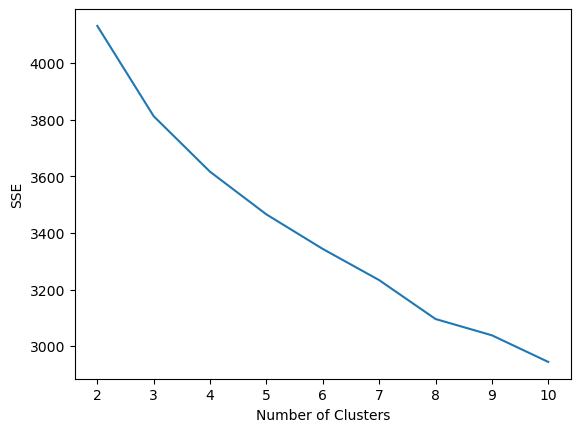

In [109]:
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Silhouette coefficients

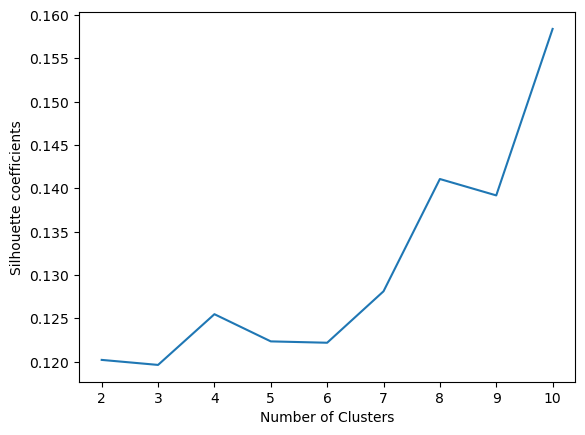

In [110]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

In [111]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
anime_clusters = kmeans.fit_predict(clustering_features)
anime_clusters_visual = kmeans.fit(clustering_features)

anime_with_clusters = anime_df.copy()
anime_with_clusters['Cluster'] = anime_clusters_visual.labels_

In [112]:
def cluster_plot(data, nclusters):
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    X = data.copy()

    km = KMeans(n_clusters=nclusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    
    # Visualize it:
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_.astype(float))

    # plot the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', label='centroids')
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

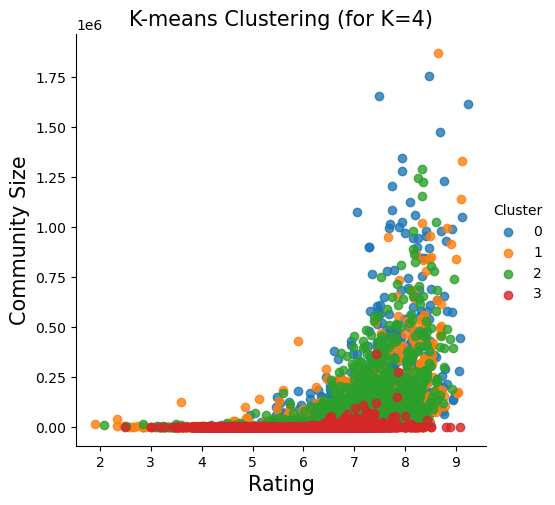

In [113]:
import seaborn as sns

sns.lmplot(x = 'rating', y = 'members', data = anime_with_clusters, hue = 'Cluster', fit_reg = False)

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('K-means Clustering (for K=4)', fontsize = 15)
plt.ylabel('Community Size', fontsize = 15)
plt.xlabel('Rating', fontsize = 15)

# display the plot
plt.show()

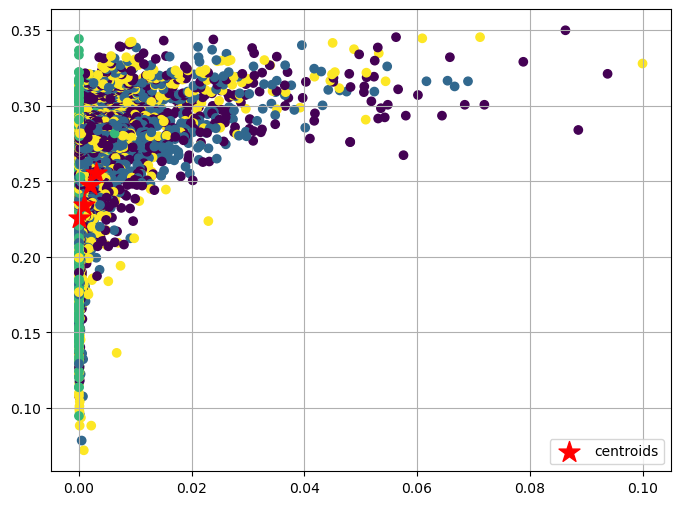

In [114]:
clusters = clustering_features
cluster_plot(clusters, 4)

Get recommendations

In [127]:
def get_similar_anime(anime_name, data, n_recommendations=100):
    anime_index = anime_df[anime_df['name'] == anime_name].index[0]
    anime_cluster = data[anime_index]
    similar_anime_indexes = [i for i, cluster in enumerate(data) if cluster == anime_cluster and i != anime_index]
    similar_anime = anime_df.iloc[similar_anime_indexes]['name'].tolist()
    
    return similar_anime[:n_recommendations+1]

In [128]:
get_similar_anime('Death Note', anime_clusters)

['Shigatsu wa Kimi no Uso',
 'Sen to Chihiro no Kamikakushi',
 'Kaguyahime no Monogatari',
 'Saraiya Goyou',
 'Byousoku 5 Centimeter',
 'Asagao to Kasesan',
 'Shokugeki no Souma Shin no Sara',
 'Koukaku Kidoutai 2 Innocence',
 'Ginga Tetsudou 999',
 'Akagami no Shirayukihime',
 'Mariasama ga Miteru 4th',
 'Charlotte',
 'Capeta',
 'Hybrid Child',
 'Ginga Eiyuu Densetsu Gaiden 1999',
 'Hello World',
 'Youkoso Jitsuryoku Shijou Shugi no Kyoushitsu e TV',
 'The Everlasting Guilty Crown',
 'Tasogare Otome x Amnesia',
 'Neko no Ongaeshi',
 'Love Live School Idol Project 2nd Season',
 'Colorful Movie',
 'Bishoujo Senshi Sailor Moon S',
 'Baby Steps',
 'Mariasama ga Miteru 3rd',
 'Hibike Euphonium Movie 3 Chikai no Finale',
 'Detective Conan Movie 08 Time Travel of the Silver Sky',
 'Planetarian Hoshi no Hito',
 'Gake no Ue no Ponyo',
 'Eikoku Koi Monogatari Emma Moldershen',
 'Clannad After Story  Mou Hitotsu no Sekai Kyouhen',
 'Ookami to Koushinryou II Ookami to Kohakuiro no Yuuutsu',
 'Les

Clustering With PCA

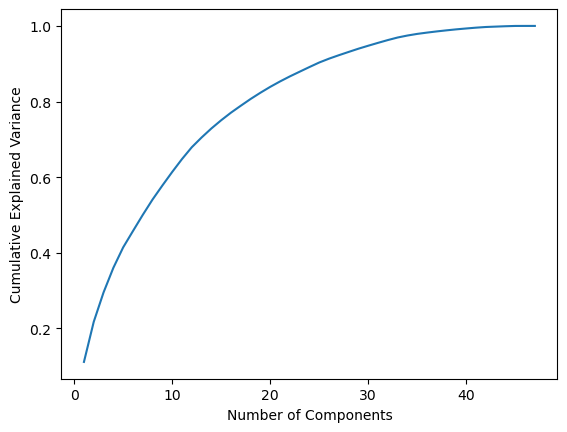

In [117]:
features = ['members_norm', 'avg_rating_norm', 'popularity_norm', 'episodes_norm'] + genres_df.columns.tolist()

selected_features_pca = normalised_anime_df[features].copy()
pca_anime_df = normalised_anime_df[features].copy()

pca = PCA().fit(pca_anime_df)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [118]:
pca = PCA(n_components=30)
pca_result = pca.fit_transform(pca_anime_df)

# compute the number of clusters to use
sse = [] #sum of squared errors

# silhouette scores range from -1 to 1: 
# 1 = points are perfectly assigned in a clsuter and clusters are easily distinguishable
# 0 = clusters are overlapping
# -1 = points are wrongly assigned in a cluster

silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10) #max_iter = 100
    kmeans.fit(pca_result)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(pca_result, kmeans.labels_)
    silhouette_coefficients.append(ss)

print("SSE: ", sse)
print("Silhouette scores: ", silhouette_coefficients)

SSE With PCA

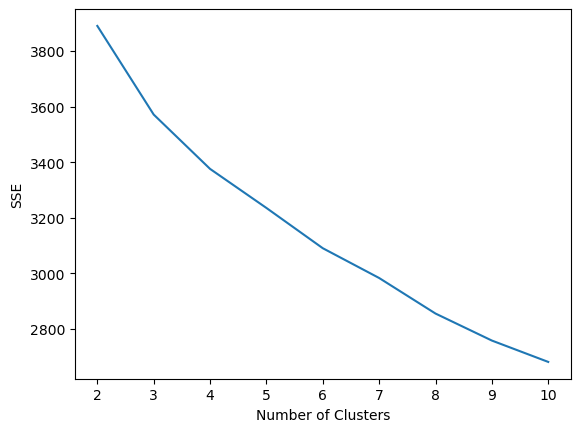

In [119]:
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Silhouette Coefficients With PCA

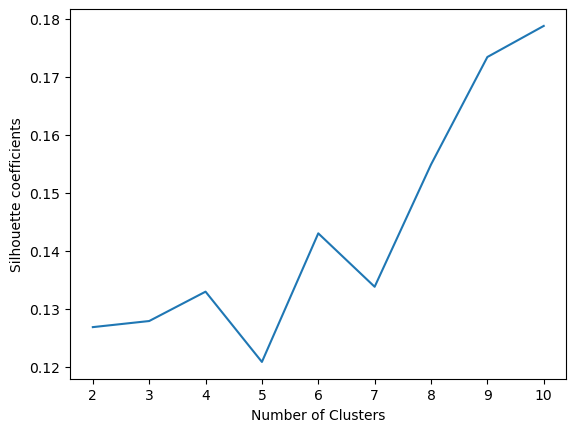

In [120]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

Get recommendations using PCA

In [121]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(pca_result)
anime_clusters_after_pca = kmeans.predict(pca_result)

In [126]:
get_similar_anime('Death Note', anime_clusters_after_pca)

['Shigatsu wa Kimi no Uso',
 'Sen to Chihiro no Kamikakushi',
 'Saraiya Goyou',
 'Byousoku 5 Centimeter',
 'Asagao to Kasesan',
 'Shokugeki no Souma Shin no Sara',
 'Mariasama ga Miteru 4th',
 'Charlotte',
 'Capeta',
 'Youkoso Jitsuryoku Shijou Shugi no Kyoushitsu e TV',
 'The Everlasting Guilty Crown',
 'Tasogare Otome x Amnesia',
 'Love Live School Idol Project 2nd Season',
 'Colorful Movie',
 'Bishoujo Senshi Sailor Moon S',
 'Baby Steps',
 'Mariasama ga Miteru 3rd',
 'Hibike Euphonium Movie 3 Chikai no Finale',
 'Detective Conan Movie 08 Time Travel of the Silver Sky',
 'Eikoku Koi Monogatari Emma Moldershen',
 'Clannad After Story  Mou Hitotsu no Sekai Kyouhen']

In [129]:
def hybrid_recs_with_clustering(anime_name, data, content_weight=0.4, collaborative_weight=0.6, num_recommendations=20):
    if anime_name not in combined_category_ratings_pivot.index:
        return []

    content_based = get_similar_anime(anime_name, data)
    collaborative_filtering = collaborative_filtering_recommendations(anime_name)

    # removing anime titles that may no longer exist within our dataframe as some were removed after the initial
    # anime_df and ratings_df dataframes were merged together
    content_based_animes = []

    for i in content_based:
        if i in combined_category_ratings_pivot.index:
            content_based_animes.append(i)

    collaborative_based_animes = []

    for i in collaborative_filtering:
        if i in combined_category_ratings_pivot.index:
            collaborative_based_animes.append(i)

    content_based_scores = combined_category_ratings_pivot.loc[content_based_animes]
    collaborative_filtering_scores = combined_category_ratings_pivot.loc[collaborative_based_animes]

    # create weighted scores for all the animes using both the values generated from content based and collaborative filtering methods
    scores = content_based_scores.mul(content_weight).add(collaborative_filtering_scores.mul(collaborative_weight), fill_value=0)
    
    weighted_scores = scores[anime_name].sort_values(ascending=False)
    return weighted_scores, weighted_scores.head(num_recommendations).index.tolist()
    

In [131]:
#Without PCA
hybrid_recs_with_clustering('Death Note', anime_clusters)

(name
 Sen to Chihiro no Kamikakushi                                          0.052121
 Fullmetal Alchemist Brotherhood                                        0.044908
 Serial Experiments Lain                                                0.039997
 Code Geass Hangyaku no Lelouch R2                                      0.039676
 Sword Art Online                                                       0.038954
                                                                          ...   
 Kara no Kyoukai Mirai Fukuin                                           0.000000
 Detective Conan Movie 08 Time Travel of the Silver Sky                 0.000000
 Cardcaptor Sakura Clear Cardhen Prologue  Sakura to Futatsu no Kuma    0.000000
 Capeta                                                                 0.000000
 Hyouge Mono                                                            0.000000
 Name: Death Note, Length: 174, dtype: float64,
 ['Sen to Chihiro no Kamikakushi',
  'Fullmetal Alchemi

In [130]:
#With PCA
hybrid_recs_with_clustering('Death Note', anime_clusters_after_pca)

(name
 Sen to Chihiro no Kamikakushi                             0.052121
 Fullmetal Alchemist Brotherhood                           0.044908
 Death Parade                                              0.044582
 Code Geass Hangyaku no Lelouch R2                         0.039676
 Sword Art Online                                          0.038954
                                                             ...   
 Detective Conan Movie 08 Time Travel of the Silver Sky    0.000000
 Girls  Panzer Movie                                       0.000000
 Kara no Kyoukai Mirai Fukuin                              0.000000
 Romeo no Aoi Sora                                         0.000000
 xxxHOLiC Rou                                              0.000000
 Name: Death Note, Length: 169, dtype: float64,
 ['Sen to Chihiro no Kamikakushi',
  'Fullmetal Alchemist Brotherhood',
  'Death Parade',
  'Code Geass Hangyaku no Lelouch R2',
  'Sword Art Online',
  'SteinsGate',
  'Elfen Lied',
  'Cowboy Bebop

With PCA

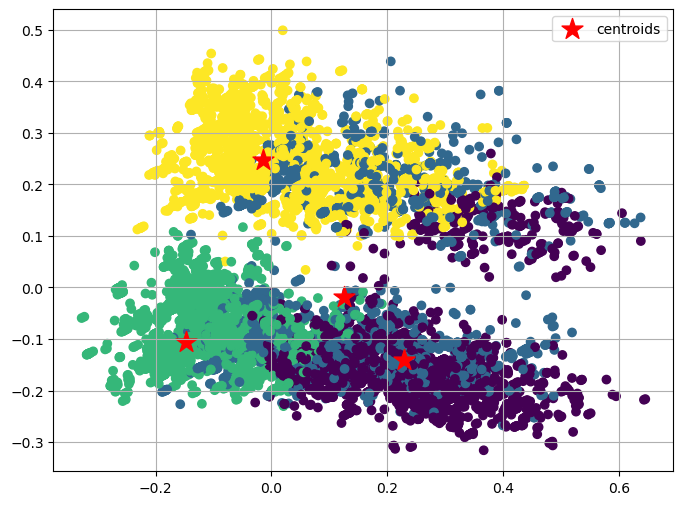

In [122]:
pca_pd = pd.DataFrame(pca_result)
cluster_plot(pca_pd, 4)

Without PCA

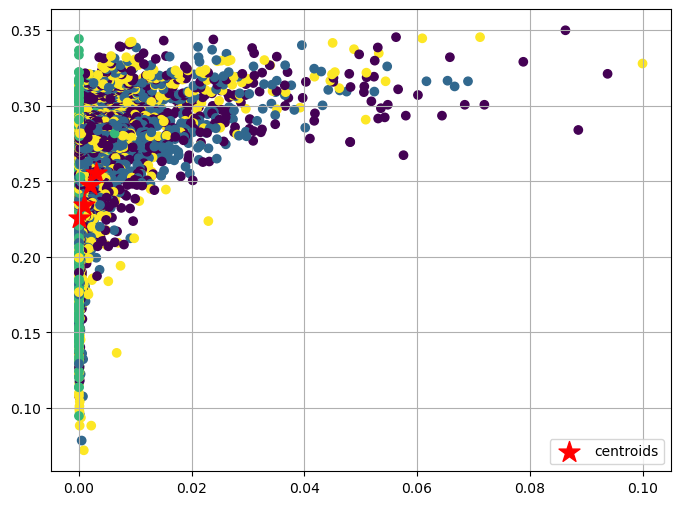

In [123]:
clusters = clustering_features
cluster_plot(clusters, 4)